In [49]:
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge

In [50]:
# Load/Preprocess Data
votes_raw = np.loadtxt('./house-votes-84.data', dtype=object, delimiter=',')
votes_raw[(votes_raw == 'republican') | (votes_raw == 'n')] = -1.
votes_raw[(votes_raw == 'democrat') | (votes_raw == 'y')] = 1.
votes_raw[votes_raw == '?'] = 0
votes = votes_raw
X, y = votes[:, 1:], votes[:, 0]
print(X.shape, y.shape)
np.savetxt('./test_export.txt', votes)

(435, 16) (435,)


# Task 1 - Spectral Clustering

In [51]:
# Function to calculate unnormalized laplacian matrix
def generateUnnormalizedLaplacian(x, sigma):
    W = np.exp(-(x**2)/(2 * sigma**2)).astype(float)
    d = np.sum(W, axis=1) # Sum rows
    D = np.diag(d) # Diagonal matrix of row sums
    L = D - W # Graph laplacian
    lam, Q = np.linalg.eigh(L) # Eigenvalues and vectors
    sort_idx = lam.argsort() # Sort index
    lam_sort = lam[sort_idx] 
    Q_sort = Q[:, sort_idx] # Apply sort
    return lam_sort, Q_sort, Q

In [52]:
# Calculate prediction accuracy of fiedler vector
def calculateAccuracy(Q, y):
    pred = np.sign(Q[:, 1])
    correct = np.count_nonzero(pred == y)
    accuracy = 1 - correct / 435
    accuracy = max(accuracy, 1 - accuracy) # Account for potential negative sign off
    return accuracy

In [53]:
# Generate spatial distance matrix
X_spatial = scipy.spatial.distance_matrix(X, X, p=2)

In [54]:
# Run for specified range
sigmas = np.arange(0.1, 4, step=0.01)
accuracies = [] # List of accuracies
for s in sigmas: # iterate through all sigma
    lam, Q, _ = generateUnnormalizedLaplacian(X_spatial, s) # Generate Laplacian
    s_acc = calculateAccuracy(Q, y) # Calculate accuracy
    accuracies.append(s_acc)

# Best Results
best_accuracy_idx = np.argmax(accuracies)
best_accuracy = accuracies[best_accuracy_idx]
best_sigma = sigmas[best_accuracy_idx]
print('Best Sigma:', best_sigma, ', Best Accuracy:', best_accuracy)

Best Sigma: 1.1599999999999995 , Best Accuracy: 0.8804597701149426


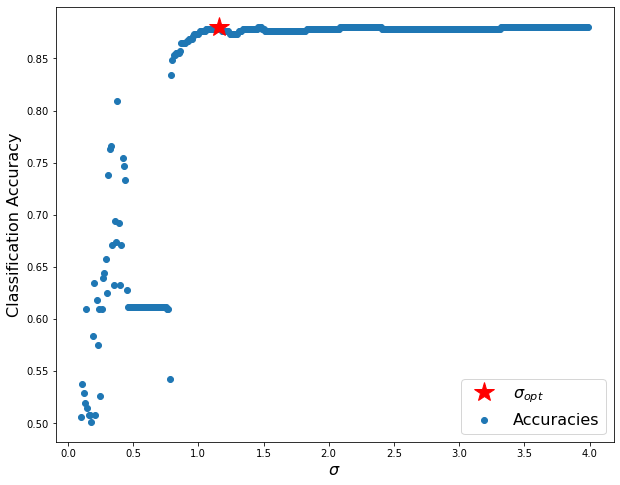

In [55]:
# Plot results
fig = plt.figure(figsize=(10,8))
plt.scatter(sigmas, accuracies, label='Accuracies')
plt.plot(best_sigma, best_accuracy, 'r*', markersize=20, label='$\sigma_{opt}$')
plt.xlabel('$\sigma$', fontsize=16)
plt.ylabel('Classification Accuracy', fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [56]:
# Plot the first three eigenvectors to see split
# _, Q_opt, Q = generateUnnormalizedLaplacian(X_spatial, best_sigma) # Get the data
# eig1 = Q[:, 1] / np.abs(Q[:, 1]).max()
# eig2 = Q[:, 2] / np.abs(Q[:, 2]).max()
# eig3 = Q[:, 3] / np.abs(Q[:, 3]).max()

# fig, ax = plt.subplots(1, 3, figsize=(24, 12))
# ax[0].scatter(eig1, eig2)
# ax[1].scatter(eig2, eig3)
# ax[2].scatter(eig1, eig3)
# # fig = plt.figure(figsize=(12, 12))
# # ax = plt.axes(projection='3d')
# # ax.scatter(, # First eigenvector
# #            , # Second eigenvector
# #            Q[:, 3] / np.abs(Q[:, 3]).max())
# # ax.set_xlabel('$q_1$')
# # ax.set_ylabel('$q_2$')
# # ax.set_zlabel('$q_3$')
# # plt.show()

# Task 2 - Semi-Supervised Learning

In [57]:
# Run models using Q_opt
J_vals = [5, 10, 20, 40] # J values to consider (rows)
M_vals = [2, 3, 4, 5, 6] # M values to consider (columns)
results = np.empty((len(J_vals), len(M_vals))) # Results vector
model = LinearRegression(fit_intercept=False) # base model
for j_i, j in enumerate(J_vals): # Iterate through all J_vals
    for m_i, m in enumerate(M_vals): # iterate through all m_vals
        A = Q_opt[0:j, 0:m] # Make A matrix
        b = y[0:j] # Make b vector
        model.fit(A, b) # Fit model
        betas = model.coef_ # Get coefficients
        pred = np.sign(np.dot(Q_opt[:, 0:m] , betas)) # Predictions
        correct = np.count_nonzero(pred == y) # how many are correct
        accuracy = 1 - correct / 435 # Convert to accuracy
        results[j_i, m_i] = accuracy # Append results
        
print(results)

[[0.11034483 0.11264368 0.16091954 0.13103448 0.13103448]
 [0.11264368 0.18390805 0.14942529 0.28965517 0.31494253]
 [0.11724138 0.17931034 0.13563218 0.16091954 0.12643678]
 [0.11954023 0.16321839 0.12413793 0.11954023 0.13563218]]
